<a href="https://colab.research.google.com/github/Agus1112/File_Analyzer_VirusTotal/blob/main/File_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

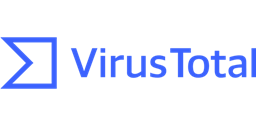

# File Analyzer





## Description:

This script allows you to scan multiple files via VirusTotal. Its use is simple:

1. Select the files you want to scan.
2. Wait on average 5 minutes and you can check the results (if this file was rated as malicious or suspicious).

Important notes:

* Only files with a maximum size of 650 MB and which do not contain a password can be scanned.
* You can also scan ZIP files with a password, provided they are smaller than 3 MB.

## Library import


In [ ]:
import concurrent.futures
import hashlib
import mimetypes
import requests
import os
import pandas as pd
import time
from google.colab import files

## API Keys

In [ ]:
VIRUS_TOTAL_AK = 'YOUR_API_KEY'

## Classes

### Virus Total

In [ ]:
import os
import requests

class VirusTotal:
  # Constructor method.
  def __init__(self, api_key):
    self.api_key = api_key
    self.url = 'https://www.virustotal.com/api/v3/files'
    self.headers = {
      "accept": "application/json",
      'x-apikey': self.api_key,
    }

  # Method to analyze file.
  def analyze_file(self, file_path, file_size):
    if file_size <= 32:
      print("File size is less than 32 MB")
      file_upload = {"file": (file_path, open(file_path, "rb"), "application/octet-stream")}
      response = requests.post(self.url, files=file_upload, headers=self.headers)
    elif 32 < file_size < 650:
      print("File size is greater than 32 MB and less than 650 MB")
      url = "https://www.virustotal.com/api/v3/files/upload_url"
      response = requests.get(url, headers=self.headers)
      url = response.json()["data"]
      file_upload = {"file": (file_path, open(file_path, "rb"), "application/octet-stream")}
      response = requests.post(url, files=file_upload, headers=self.headers)
    else:
      print("ERROR: File size is greater than 650 MB")
      return {"ERROR": "File size is greater than 650 MB"}
    return response.json()

  # Method to analyze ZIP file.
  def analyze_zip_file(self, file_path, file_size, password=None):
    if file_size <= 3:
      print("File size is less than 3 MB")
      payload = { "password": password }
      file_upload = {"file": (file_path, open(file_path, "rb"), "application/octet-stream")}
      response = requests.post(self.url, data=payload, files=file_upload, headers=self.headers)
    else:
      print("ERROR: File size is greater than 3 MB")
      return {"ERROR": "File size is greater than 3 MB"}
    return response.json()

  # Method to get report.
  def get_analysis_report(self, analysis_id):
    url = f"https://www.virustotal.com/api/v3/analyses/{analysis_id}"
    response = requests.get(url, headers=self.headers)
    return response.json()

## Functions

### File upload

This function allows you to upload files.

In [ ]:
def upload_files():
  files_upload = files.upload()
  return files_upload

### Get SHA-256 Hash

This function receives the path of a file, computes, and returns its SHA-256 hash.




In [ ]:
def get_sha_256_hash(file_path):
  sha256_hash = hashlib.sha256()
  try:
    with open(file_path, "rb") as file: # Reading file in binary mode.
      for byte_block in iter(lambda: file.read(4096), b""): # Reading the file in 4k blocks.
        sha256_hash.update(byte_block) # Update hash with byte block.
      return sha256_hash.hexdigest()
  except FileNotFoundError:
    return f"ERROR: The file '{file_path}' was not found."
  except Exception as e:
    return f"ERROR: {e}"

### Get file size (MB)

This function receives the path of a file, computes, and returns its size in MB.

In [ ]:
def get_file_size(file_path):
  try:
    size_file_bytes = os.path.getsize(file_path) # Get the file size in bytes
    size_file_mb = size_file_bytes / (1024 * 1024)
    return round(size_file_mb, 2)
  except FileNotFoundError:
    return f"ERROR: The file '{file_path}' was not found."
  except Exception as e:
    return f"ERROR: {e}"

## Analysis

In [ ]:
# Analysis.
results = {
    "FILE": list(),
    "TYPE": list(),
    "SIZE (MB)": list(),
    "MALICIOUS": list(),
    "SUSPICIOUS": list(),
    "SHA-256": list()
}

# Dictionary that stores the analysis IDs.
analysis_ids = dict()

# CTI instances.
vt = VirusTotal(VIRUS_TOTAL_AK)

# Upload files.
files = upload_files()

for file_upload in files:

  # File characterization.
  file_path = file_upload
  mime_type, _ = mimetypes.guess_type(file_path) # Automatically detect MIME type.
  file_size = get_file_size(file_path)

  if mime_type is None:
    mime_type = "application/octet-stream" # Set a default MIME type.

  if get_sha_256_hash(file_path) in results["SHA-256"]:
    continue

  results["FILE"].append(file_path)
  results["TYPE"].append(mime_type)
  results["SIZE (MB)"].append(file_size)
  results["MALICIOUS"].append("N/D")
  results["SUSPICIOUS"].append("N/D")
  results["SHA-256"].append(get_sha_256_hash(file_path))

  # File Analysis.
  report = vt.analyze_file(file_path, file_size)
  analysis_ids[get_sha_256_hash(file_path)] = report["data"]["id"]

df = pd.DataFrame(results)
display(df)

##Waiting time

In [ ]:
time.sleep(300)

##Results

In [ ]:
results["MALICIOUS"].clear()
results["SUSPICIOUS"].clear()

for analysis_id, report_id in analysis_ids.items():
  report = vt.get_analysis_report(report_id)
  print(report)
  results["MALICIOUS"].append(report.get("data", {}).get("attributes", {}).get("stats", {}).get("malicious", "N/D"))
  results["SUSPICIOUS"].append(report.get("data", {}).get("attributes", {}).get("stats", {}).get("suspicious", "N/D"))

df = pd.DataFrame(results)
display(df)

##ZIP File Analysis

In [ ]:
# Analysis.
results = {
    "FILE": list(),
    "TYPE": list(),
    "SIZE (MB)": list(),
    "MALICIOUS": list(),
    "SUSPICIOUS": list(),
    "SHA-256": list()
}

# Dictionary that stores the analysis IDs.
analysis_ids = dict()

# CTI instances.
vt = VirusTotal(VIRUS_TOTAL_AK)
password = "infected"

# Upload files.
files = upload_files()

for file_upload in files:

  # File characterization.
  file_path = file_upload
  mime_type, _ = mimetypes.guess_type(file_path) # Automatically detect MIME type.
  file_size = get_file_size(file_path)

  if mime_type is None:
    mime_type = "application/octet-stream" # Set a default MIME type.

  if get_sha_256_hash(file_path) in results["SHA-256"]:
    continue

  results["FILE"].append(file_path)
  results["TYPE"].append(mime_type)
  results["SIZE (MB)"].append(file_size)
  results["MALICIOUS"].append("N/D")
  results["SUSPICIOUS"].append("N/D")
  results["SHA-256"].append(get_sha_256_hash(file_path))

  # File Analysis.
  report = vt.analyze_zip_file(file_path, file_size, password)
  analysis_ids[get_sha_256_hash(file_path)] = report["data"]["id"]

df = pd.DataFrame(results)
display(df)

##Waiting time

In [ ]:
time.sleep(300)

##Results

In [ ]:
results["MALICIOUS"].clear()
results["SUSPICIOUS"].clear()

for analysis_id, report_id in analysis_ids.items():
  report = vt.get_analysis_report(report_id)
  print(report)
  results["MALICIOUS"].append(report.get("data", {}).get("attributes", {}).get("stats", {}).get("malicious", "N/D"))
  results["SUSPICIOUS"].append(report.get("data", {}).get("attributes", {}).get("stats", {}).get("suspicious", "N/D"))

df = pd.DataFrame(results)
display(df)